# Project Goal: Speaker Identification and Speech Recognition

With the rise of deep learning and the advancement of hardware to enable it, the accuracy and reliability of audio-related methodologies have seen a huge boon in the past decade. In particular, such techniques have found widespread usage through systems such as natural-language assistants (Siri, Alexa etc.), automatic captioning in videos, and natural speech generation for a variety of user-facing applications and gadgets. 

Here, I dip my toes into the world of audio processing with deep learning, by engaging in two fundamental tasks for audio processing:
1. Speaker identification, where I will map speakers to names based on short audio clips
2. Speech recognition, which is the converision of the audio waveform to text. 

With sufficient accuracy, the combination of these two techniques yields a robust and  accurate transcription tool, helping to automate the menial task traditionally performed by scribes.  

# Importing dependencies

In [ ]:
!pip install pydrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:

!pip install soundfile
!pip install librosa

import numpy as np
import matplotlib.pyplot as plt
import os 
import soundfile
from IPython.display import Audio as audio_playback_widget
import IPython.display as ipd

# Dataset download and unzipping

The original LibriSpeech corpus is derived from audiobooks that are part of the LibriVox project,  and contains about 1000 hours of read English speech at 16kHz. Here, we utilize a small subset of this corpus, containing about 100 hours of cleaned speech. Source: http://www.openslr.org/12/

For archival purposes mainly, do not run if you already have this data in your Drive. (The 6.4GB LibriSpeech dataset takes 3 hours to download)

In [ ]:
!wget --header="Host: openslr.magicdatatech.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en;q=0.9,zh-CN;q=0.8,zh;q=0.7,en-US;q=0.6" --header="Referer: http://www.openslr.org/12/" "http://openslr.magicdatatech.com/resources/12/train-clean-100.tar.gz" -c -O 'train-clean-100.tar.gz'

--2020-09-22 22:29:52--  http://openslr.magicdatatech.com/resources/12/train-clean-100.tar.gz
Resolving openslr.magicdatatech.com (openslr.magicdatatech.com)... 39.96.249.211
Connecting to openslr.magicdatatech.com (openslr.magicdatatech.com)|39.96.249.211|:80... ^C


In [ ]:
embed_file = drive.CreateFile({'title' : 'train-clean-100.tar.gz'})
embed_file.SetContentFile( 'train-clean-100.tar.gz')
embed_file.Upload()

In [ ]:
%%bash
mkdir "/content/drive/My Drive/speaker_audio_corpus"
tar -xvf '/content/drive/My Drive/train-clean-100.tar.gz' -C '/content/drive/My Drive/speaker_audio_corpus/'

# Data exploration

In [ ]:
## The LibriSpeech folder contains information about their speakers, the books and chapters that they are reading from, as well as the corpus 
## of audio files for each speaker. 

for f in os.listdir('/content/drive/My Drive/speaker_audio_corpus/LibriSpeech/'):
  print(f)

LICENSE.TXT
SPEAKERS.TXT
CHAPTERS.TXT
README.TXT
BOOKS.TXT
train-clean-100


In [ ]:
## Each speaker has their own folder containing all their audio files. Each speaker is identified with a particular ID, as shown below. 

print('Example speakers:')
for i, f in enumerate(os.listdir('/content/drive/My Drive/speaker_audio_corpus/LibriSpeech/train-clean-100')):
  if i > 4:
    continue
  print(f)
  
print("")
print("There are {} speakers in all.".format(i+1))

Example speakers:
6818
6147
5022
2910
3983

There are 251 speakers in all


In [ ]:
## In each speaker's folder, the audio clips are further partitioned based on which chapters of the audio book they originated from. For our purposes,
## we do not really care about this separation.

# Example speaker
for i, f in enumerate(os.listdir('/content/drive/My Drive/speaker_audio_corpus/LibriSpeech/train-clean-100/6818')):
  print(f)

print("")
print("Speaker with ID 6818 has audio clips from {} chapters".format(i+1))

68772
76332

Speaker with ID 6818 has audio clips from 2 chapters


In [ ]:
## In each partition, the audio clips are stored in the FLAC (free lossless audio codec) format. They are typically about 10-15s long. 

for i, f in enumerate(os.listdir('/content/drive/My Drive/speaker_audio_corpus/LibriSpeech/train-clean-100/6818/68772')):
  if i > 4:
    continue
  print(f)

print("")
print("There are {} clips in this partition".format(i))

6818-68772-0020.flac
6818-68772-0007.flac
6818-68772-0014.flac
6818-68772-0022.flac
6818-68772-0034.flac

There are 51 clips in this partition


In [ ]:
## In each partition, there is a text file containing the transcription of each audio clip. 

f = open("/content/drive/My Drive/speaker_audio_corpus/LibriSpeech/train-clean-100/6454/107462/6454-107462.trans.txt", 'r')

for x in f.readlines():
  print(x)
  break

6454-107462-0000 PATRICK DEASEY DESCRIBED HIMSELF AS A PHILOSOPHER PSYCHOLOGIST AND HUMORIST IT WAS PARTLY BECAUSE PATRICK DELIGHTED IN LONG WORDS AND PARTLY TO EXCUSE HIMSELF



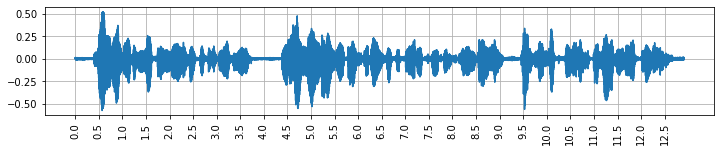

In [ ]:
# Exploring a single audio file
fold = "/content/drive/My Drive/speaker_audio_corpus/LibriSpeech/train-clean-100/4640/19189/"
f = fold + os.listdir(fold)[1]
samples, sample_rate = soundfile.read(f)

def show_waveform(sound):
    n_samples = sound.shape[0]

    plt.figure(figsize=(12,2))
    plt.plot(np.arange(0.0, n_samples)/sample_rate, sound)
    plt.xticks( np.arange(0.0, n_samples/sample_rate, 0.5), rotation=90 )

    plt.grid(True)

    plt.show()

show_waveform(samples)
audio_playback_widget(f)

In [ ]:
## exploring several voice clips
root = '/content/drive/My Drive/speaker_audio_corpus/LibriSpeech/train-clean-100/'
a = {}
for i, fold in enumerate(os.listdir(root)):
  if not a.get(fold, False):
    if i >= 50 and i < 55:
      f1 = os.path.join(root,fold)
      f2 = os.path.join(f1, os.listdir(f1)[0])
      f = os.path.join(f2, os.listdir(f2)[0])
      print(fold)
      ipd.display(audio_playback_widget(f))
    

4195


3112


2989


2764


125


In [ ]:
f = open("/content/drive/My Drive/speaker_audio_corpus/LibriSpeech/README.TXT", 'r')

for x in f.readlines():
  print(x)

In [ ]:
## Converting the speaker information text file into a format readable by pandas
f = open('/content/drive/My Drive/speaker_audio_corpus/LibriSpeech/SPEAKERS.TXT')

with open("metadata.txt", "w+") as meta:
  for line in f.readlines():
    if line[0] == ";":
      continue
    line = line.replace(" ", "")
    line = line.replace("||", "|")
    line = line.replace("W|", "W")
    meta.write(line)

In [ ]:
## Now all the lines are separated by |, so it is readable with pandas.read_csv

with open("metadata.txt", "r") as meta:
  for i, line in enumerate(meta.readlines()):
    if i == 32:
      print(line)

60|M|train-clean-100|20.18|CBWSimon



In [ ]:
import pandas as pd
metadata = pd.read_csv('metadata.txt', sep="|", names=['ID', 'Gender', 'Subset', 'Minutes', 'Speaker'])
print(metadata.head())

   ID Gender           Subset  Minutes          Speaker
0  14      F  train-clean-360    25.03   KristinLeMoine
1  16      F  train-clean-360    25.11    AlysAtteWater
2  17      M  train-clean-360    25.04    GordMackenzie
3  19      F  train-clean-100    25.19  KaraShallenberg
4  20      F  train-other-500    30.07           Gesine


In [ ]:
train_100 = metadata[(metadata["Subset"] == "train-clean-100")]
print("There are {} speakers in the train-clean-100 subset.".format(train_100.shape[0]))
male_speakers = metadata[(metadata["Subset"] == "train-clean-100") & (metadata['Gender'] == "M")]
print("There are {} male speakers in this subset.".format(male_speakers.shape[0]))
female_speakers = metadata[(metadata["Subset"] == "train-clean-100") & (metadata['Gender'] == "F")]
print("There are {} female speakers in this subset.".format(female_speakers.shape[0]))

There are 251 speakers in the train-clean-100 subset.
There are 126 male speakers in this subset.
There are 125 female speakers in this subset.


In [ ]:
## most speakers have around 25 minutes of speech.

train_100['Minutes'].describe()

count    251.000000
mean      24.045458
std        2.693576
min        5.440000
25%       24.940000
50%       25.080000
75%       25.160000
max       25.250000
Name: Minutes, dtype: float64

In [ ]:
train_100[train_100['Minutes'] < 10]

,ID,Gender,Subset,Minutes,Speaker
441,1183,F,train-clean-100,9.72,roolynninms
2071,7312,M,train-clean-100,5.44,nkneer


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0b8c70b710>]],
      dtype=object)

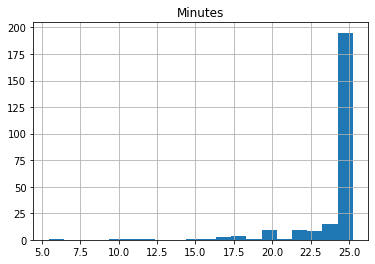

In [ ]:
train_100.hist('Minutes', bins=20)

In [ ]:
## Converting the transcription text files into a format readable by pandas

for author in os.listdir("/content/drive/My Drive/speaker_audio_corpus/LibriSpeech/train-clean-100/"):
  for book in os.listdir("/content/drive/My Drive/speaker_audio_corpus/LibriSpeech/train-clean-100/" + author):  
    f = open("/content/drive/My Drive/speaker_audio_corpus/LibriSpeech/train-clean-100/{}/{}/{}-{}.trans.txt".format(author, book,author, book), 'r')

    with open("/content/drive/My Drive/speaker_audio_corpus/LibriSpeech/train-clean-100/{}/{}/{}-{}-revised.txt".format(author, book, author, book), "w+") as new_text:
      for line in f.readlines():
       
        newline = ",".join(line.split(" ", 1)) 
        
        new_text.write(newline)




In [ ]:
all_lines = pd.DataFrame(columns=["id", "content"])
for author in os.listdir("/content/drive/My Drive/speaker_audio_corpus/LibriSpeech/train-clean-100/"):
  for book in os.listdir("/content/drive/My Drive/speaker_audio_corpus/LibriSpeech/train-clean-100/" + author):
    fn = "/content/drive/My Drive/speaker_audio_corpus/LibriSpeech/train-clean-100/{}/{}/{}-{}-revised.txt".format(author, book,author, book)
    part_line = pd.read_csv(fn, names=["id", "content"])
    all_lines = pd.concat([all_lines, part_line])

In [ ]:
all_lines

,id,content
0,6818-68772-0000,CHAPTER THIRTEEN THE BOOMERANG THE LAWN FETE W...
1,6818-68772-0001,FORBES FOR REPRESENTATIVE CERTAIN EDIBLES SUCH...
2,6818-68772-0002,BUT THEY ATE THE DAINTIES WITH A WISE DISREGAR...
3,6818-68772-0003,WAS INSUFFICIENT TO COPE WITH SUCH A THRONG HE...
4,6818-68772-0004,AFTER LUNCHEON BEGAN THE SPEECH MAKING INTERSP...
...,...,...
49,1624-168623-0049,THE MAN AND THE WOMAN EACH HAD A DIFFERENT MET...
50,1624-168623-0050,COSETTE RAN UP STAIRS AND DOWN WASHED SWEPT RU...
51,1624-168623-0051,A FIERCE MISTRESS AND VENOMOUS MASTER THE THEN...
52,1624-168623-0052,IT WAS SOMETHING LIKE THE FLY SERVING THE SPID...


In [ ]:
import pandas as pd
trial = pd.read_csv("/content/drive/My Drive/speaker_audio_corpus/LibriSpeech/train-clean-100/4406/16883/4406-16883.trans.txt", delimiter=" ", names=["id", "content"])

In [ ]:
## merging speaker and transcription info into a single file.
## Note: I actually did the transcription merging in another cell but I lost it. So just pretend this is where I added the transcripts ok? :) 

clip_info = pd.DataFrame(columns=['speaker_id', 'chapter', 'clip_path', 'id'])
clip_info
i = 0
root = "/content/drive/My Drive/speaker_audio_corpus/LibriSpeech/train-clean-100/"
for speaker in os.listdir(root):
  for top, _, fns in os.walk(os.path.join(root, speaker)): 
    for fn in fns:
      if fn[-3:] == 'txt':
        continue
      clip_info.loc[i, 'speaker_id'] = speaker
      clip_info.loc[i, 'chapter'] = fn[5:10]
     
      clip_info.loc[i, 'clip_path'] = os.path.join(top, fn)
      clip_info.loc[i, 'id'] = fn[:-5]
      i += 1
      





In [ ]:
clip_info

,speaker_id,chapter,clip_path,id
0,6818,68772,/content/drive/My Drive/speaker_audio_corpus/L...,6818-68772-0020
1,6818,68772,/content/drive/My Drive/speaker_audio_corpus/L...,6818-68772-0007
2,6818,68772,/content/drive/My Drive/speaker_audio_corpus/L...,6818-68772-0014
3,6818,68772,/content/drive/My Drive/speaker_audio_corpus/L...,6818-68772-0022
4,6818,68772,/content/drive/My Drive/speaker_audio_corpus/L...,6818-68772-0034
...,...,...,...,...
28534,1624,16862,/content/drive/My Drive/speaker_audio_corpus/L...,1624-168623-0029
28535,1624,16862,/content/drive/My Drive/speaker_audio_corpus/L...,1624-168623-0006
28536,1624,16862,/content/drive/My Drive/speaker_audio_corpus/L...,1624-168623-0026
28537,1624,16862,/content/drive/My Drive/speaker_audio_corpus/L...,1624-168623-0018


In [ ]:
embed_file = drive.CreateFile({'title' : 'clip_info.csv'})
embed_file.SetContentFile( 'clip_info.csv')
embed_file.Upload()

In [ ]:
import pandas as pd
clip_info = pd.read_csv('/content/drive/My Drive/clip_info_finalest.csv')

In [ ]:
clip_info.head()

,speaker_id,chapter,clip_path,id,content,count,final_path
0,6818,68772,/content/drive/My Drive/speaker_audio_corpus/L...,6818-68772-0020,INDEED THERE WERE MORE KINDLY THOUGHTS EXPRESS...,1,/content/content/drive/My Drive/reddragon/spec...
1,6818,68772,/content/drive/My Drive/speaker_audio_corpus/L...,6818-68772-0007,THEY HAD CROWDED THEMSELVES INTO MORE PROMINEN...,2,/content/content/drive/My Drive/reddragon/spec...
2,6818,68772,/content/drive/My Drive/speaker_audio_corpus/L...,6818-68772-0014,IF HE HONESTLY DESIRED TO DO SO THAT WAS WHAT ...,3,/content/content/drive/My Drive/reddragon/spec...
3,6818,68772,/content/drive/My Drive/speaker_audio_corpus/L...,6818-68772-0022,BUT PATSY'S WISE LITTLE HEAD COUNSELLED CAUTIO...,4,/content/content/drive/My Drive/reddragon/spec...
4,6818,68772,/content/drive/My Drive/speaker_audio_corpus/L...,6818-68772-0034,TO SETTLE THIS ARGUMENT IN JOINT DEBATE THE GI...,5,/content/content/drive/My Drive/reddragon/spec...


#Tabular feature extraction

Extracting tabular information from each audio clip using librosa for use in the feedforward network.

Full credit goes to Jurgen Arias' Medium article for the features used:
https://towardsdatascience.com/voice-classification-with-neural-networks-ff90f94358ec

Full credit goes to Valerio Velardo for his awesome Audio Signal Processing for Machine Learning course, without which my dumb brain would never have comprehended any of this: https://www.youtube.com/playlist?list=PL-wATfeyAMNqIee7cH3q1bh4QJFAaeNv0 

Quick explanation of each tabular feature used:

**Mel-Frequency Cepstrum Coefficients (MFCCs):** 
1. Move from the time to frequency domain with Discrete Fourier Transform. (DFT) 
2. Convert the signal to perceptually-relevant amplitudes (decibels) using log scaling. 
3. Convert the signal to perceptually-relevant frequencies by Mel-scaling the spectrum. (log-based binning with triangular filters.) 
4. Perform the discrete cosine transform (similar to inverse DFT) on the Mel bins, as if they were a signal. 
5. This yields the cepstrum, with its corresponding quefrencies. (aka magnitude of each value on the x-axis). Use "liftering" (filtering) to remove high quefrencies associated with the glottal pulse. (basal sound created by vocal folds, containing information about pitch) 
6. This yields a set of MFCC coefficients. Since most of the information is contained in the first few coefficients, the typical approach is to extract about 11-13 coefficeints. However, the approach of the author was to take 40 coefficients. 

**Chromagram:**

Basically a spectrogram based on the 12 pitch classes. (C, C#, D, D# etc.) Useful in capturing melodic/harmonic characteristics in music, agnostic of instrumentation or timbre. 

**Melspectrogram:**

A spectrogram based on Mel-scaling. The short-time Fourier Transform is mapped onto the Mel scale (logarithmically based scale analogous to how humans perceive pitch), and triangular Mel filters are produced. Dot product of the Mel filters and normal spectogram produced by STFT yields the Melspectrogram.

**Spectral Contrast:** 

A spectral feature that considers the spectral peak, spectral valleys and their differences in each sub-band. (eg. octave scale filters) Useful in capturing information about spectral distribution within in a time frame, which is lost in features such as MFCCs since they average the spectral information in each sub-band.  



In [29]:
%%time
import librosa

def extract_tabular(file_path):
   

    X, sample_rate = librosa.load(file_path, res_type='kaiser_fast') 

    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)

    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))

    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)

    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

    # Computes the tonal centroid features (tonnetz)
    #tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    #sr=sample_rate).T,axis=0)
    

    return np.concatenate([mfccs, chroma, mel, contrast])


CPU times: user 826 ms, sys: 172 ms, total: 998 ms
Wall time: 2.54 s


In [30]:
%%time
## Extracting all the features from the clips and saving to a dataframe. This took 6 hours. 
tab_info = pd.DataFrame()
root = "/content/reddragon/"
for i in range(len(clip_info)):
  if i < 23033:
    continue
  row = clip_info.iloc[i]
  file_path = row["clip_path"]
  speaker = str(row["speaker_id"])
  
  fn = row['id']

  spec = extract_tabular(file_path)
  spec = pd.DataFrame(spec)
  tab_info = pd.concat([tab_info, spec], axis=1)
  if i % 1000 == 0:
    print(i)


KeyboardInterrupt: ignored

In [ ]:
tab_info_p4 = tab_info.values.T
np.save("/content/drive/My Drive/tab_info_p4.npy", tab_info_p4)

In [ ]:
## Had to do it in 4 parts, since it took so long.

ti1 = np.load("/content/drive/My Drive/tab_info_p1.npy")
ti2 = np.load("/content/drive/My Drive/tab_info_p2.npy")
ti3 = np.load("/content/drive/My Drive/tab_info_p3.npy")
ti4 = np.load("/content/drive/My Drive/tab_info_p4.npy")

ti = np.concatenate([ti1, ti2, ti3, ti4])
np.save("/content/drive/My Drive/tab_info_complete.npy", ti)

#Extracting spectrogram images 

Extracting spectrogram images from audio clips for use in the CNN model 

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 551, None, 16)     80        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 275, None, 16)     0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 275, None, 16)     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 274, None, 32)     2080      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 137, None, 32)     0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 137, None, 32)     0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 136, None, 64)    

In [ ]:
import librosa
import numpy as np

## obtaining the Melspectrogram from the raw audio clips.

def extract_features(file_name, sample_rate=16000):
   
    try:
        data, _ = librosa.core.load(file_name, sr= sample_rate, res_type="kaiser_fast")
        melspec = librosa.feature.melspectrogram(data, sr= sample_rate, n_mels=128)
        logspec = librosa.core.power_to_db(melspec) # shape would be [128, your_audio_length]
        
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
     
    return logspec


In [ ]:
%%time

## testing out the speed of conversion + some visualizations

spec1 = extract_features('/content/drive/My Drive/speaker_audio_corpus/LibriSpeech/train-clean-100/4640/19188/4640-19188-0021.flac')
spec2 = extract_features('/content/drive/My Drive/speaker_audio_corpus/LibriSpeech/train-clean-100/4640/19188/4640-19188-0001.flac')

spec3 = extract_features("/content/drive/My Drive/speaker_audio_corpus/LibriSpeech/train-clean-100/2843/152918/2843-152918-0074.flac")
spec4 = extract_features("/content/drive/My Drive/speaker_audio_corpus/LibriSpeech/train-clean-100/2843/152918/2843-152918-0091.flac")

spec5 = extract_features("/content/drive/My Drive/speaker_audio_corpus/LibriSpeech/train-clean-100/8425/287387/8425-287387-0001.flac")
spec6 = extract_features("/content/drive/My Drive/speaker_audio_corpus/LibriSpeech/train-clean-100/8425/287387/8425-287387-0007.flac")

spec7 = extract_features("/content/drive/My Drive/speaker_audio_corpus/LibriSpeech/train-clean-100/5192/19396/5192-19396-0004.flac")
spec8 = extract_features("/content/drive/My Drive/speaker_audio_corpus/LibriSpeech/train-clean-100/5192/19396/5192-19396-0000.flac")

CPU times: user 358 ms, sys: 313 ms, total: 671 ms
Wall time: 1.94 s


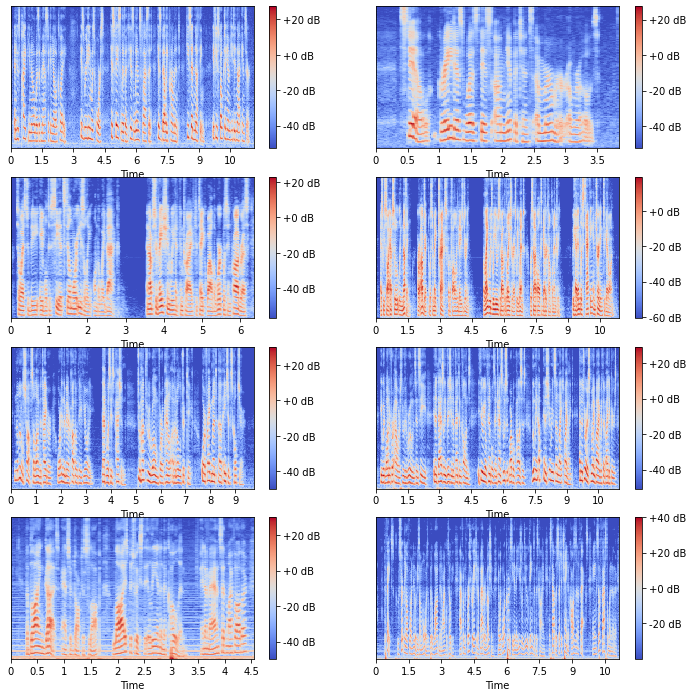

In [ ]:
import matplotlib.pyplot as plt
from librosa import display

plt.figure(figsize=(12,12))
plt.subplot(4,2,1)
display.specshow(spec1, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.subplot(4,2,2)
display.specshow(spec2, x_axis='time')
plt.colorbar(format='%+2.0f dB')

plt.subplot(4,2,3)
display.specshow(spec3, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.subplot(4,2,4)
display.specshow(spec4, x_axis='time')
plt.colorbar(format='%+2.0f dB')

plt.subplot(4,2,5)
display.specshow(spec5, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.subplot(4,2,6)
display.specshow(spec6, x_axis='time')
plt.colorbar(format='%+2.0f dB')

plt.subplot(4,2,7)
display.specshow(spec7, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.subplot(4,2,8)
display.specshow(spec8, x_axis='time')
plt.colorbar(format='%+2.0f dB')

In [ ]:
%%time

## I love waiting. 

from PIL import Image
from collections import defaultdict 

counter = defaultdict(lambda:0)

root = "/content/reddragon/"
for i in range(len(clip_info)):
  row = clip_info.iloc[i]
  file_path = row["clip_path"]
  speaker = str(row["speaker_id"])
  
  fn = row['id']

  spec = extract_features(file_path)
  if not os.path.exists(os.path.join(root,speaker)):
    os.makedirs(os.path.join(root,speaker))
  np.save("{}/{}/{}".format(root, speaker, fn), spec)

CPU times: user 21min 57s, sys: 19min 47s, total: 41min 44s
Wall time: 7h 12min 4s


In [ ]:
!zip -r "reddragon_spectrograms.zip" "/content/reddragon/"
!cp "reddragon_spectrograms.zip" "/content/drive/My Drive/reddragon_spectrograms.zip"

#Playing with CNN models

Exploring some CNN models for variable length audio input, from various papers/articles. 

Nothing much to see here, justly mostly preserved for archival purposes.

In [ ]:
from tensorflow.keras.layers import *
from tensorflow import keras
from tensorflow.keras import Sequential

## model1 
## https://arxiv.org/pdf/1607.02857.pdf

spec_width = 552
inp = Input((spec_width, None, 1))
x = Conv2D(256, (spec_width, 1), padding='valid', activation='relu')(inp)
#newdim = tuple([x for x in old_layer.shape.as_list() if x != 1 and x is not None])
#x = Reshape((newdim))(x)
x = Conv2D(256, kernel_size=(1,3), strides=(1,2), padding='valid', activation='relu')(x)
x = Conv2D(256, kernel_size=(1,3), strides=(1,2), padding='same', activation='relu')(x)
x = Conv2D(256, kernel_size=(1,3), strides=(1,2), padding='same', activation='relu')(x)
x = GlobalMaxPool2D('channels_last')(x)
out = Dense(15, activation='softmax')(x)
model = keras.Model(inputs=inp, outputs=out)

## model2
## https://arxiv.org/pdf/1604.06338.pdf
from keras import backend as K 

spec_height = 552
inp = Input(( None,  spec_height, 1))

x1 = Conv2D(10, kernel_size=(1,spec_height), padding='valid', activation='relu')(inp)
#x1 = Permute((1,3,2))(x1)
x1 = GlobalMaxPool2D()(x1)


x2 = Conv2D(10, kernel_size=(3,spec_height), padding='valid', activation='relu')(inp)
#x2 = Permute((1,3,2))(x2)
x2 = GlobalMaxPool2D()(x2)

x3 = Conv2D(10, kernel_size=(5,spec_height), padding='valid', activation='relu')(inp)
#x3 = Permute((1,3,2))(x3)
x3 = GlobalMaxPool2D()(x3)

r = Concatenate()([x1,x2,x3])

out = Dense(15, activation='softmax')(r)
model = keras.Model(inputs=inp, outputs=out)

# model3
# https://medium.com/@mikesmales/sound-classification-using-deep-learning-8bc2aa1990b7

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(552, None, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(15, activation='softmax'))

CPU times: user 1.85 ms, sys: 0 ns, total: 1.85 ms
Wall time: 1.33 ms
